# Power analysis

In [46]:
import os
import sys

sys.path.append('../')
from utils import settings
from utils.helper import ensure_list

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from itertools import product

In [47]:
%config InlineBackend.figure_format='retina'

new_rc_params = {
    "text.usetex": False,
    "svg.fonttype": 'none',
    "font.size": 7,
}
plt.rcParams.update(new_rc_params)

In [48]:
model_names = settings.MODEL_TITLE_NAMES
model_colors = settings.MODEL_COLORS

In [49]:
N_SNPS_TESTED = settings.N_SNPS

def load_results(gvar, fevgxc, ncontexts, model, context, ntested):
    f = f'../results/simulated/gvar~{gvar}_fevgxc~{fevgxc}_ncontexts~{ncontexts}_model~{model}_context~{context}_ntested~{ntested}_pvals.txt'
    return pd.read_csv(f, index_col=0, header=None, names=['gene'] + [f'var{i}' for i in range(settings.N_SNPS)])

def compute_power(df, threshold=0.01):
    return (df['var0'] * N_SNPS_TESTED < threshold).mean(), -np.log10(df['var0'].median() * N_SNPS_TESTED)

def get_pval(df, threshold=0.01):
    return df['var0'] * N_SNPS_TESTED

def create_df(gvar, fevgxc, ncontexts, model, context, ntested):
    df = pd.DataFrame(columns=['gvar', 'fevgxc', 'ncontexts', 'Model', 'context', 'ntested', 'power'])
    for i, v in enumerate(product(gvar, fevgxc, ncontexts, model, context, ntested)):
        r = pd.DataFrame(dict(zip(['gvar', 'fevgxc', 'ncontexts', 'Model', 'context', 'ntested'], v)), index=[i])
        r[['power', 'median_p']] = compute_power(load_results(*v))
        df = pd.concat([df, r])
    df['Model'] = df['Model'].replace(model_names)
    return df

## Discrete environments

In [55]:
gvar=ensure_list(settings.GENETIC_VAR)
fevgxc=[settings.FEV_GXC_DEFAULT]
ncontexts=[settings.NUM_CONTEXTS_DEFAULT]
model=['cellregmap']

In [65]:
df = pd.DataFrame({
    'pvals_mofa' : load_results(
        gvar=gvar[0], 
        fevgxc=fevgxc[0], 
        ncontexts=ncontexts[0], 
        model=model[0], 
        context='mofa', 
        ntested=settings.NUM_TESTED_DEFAULT).to_numpy().flatten(),
    'pvals_day' : load_results(
        gvar=gvar[0], 
        fevgxc=fevgxc[0], 
        ncontexts=ncontexts[0], 
        model=model[0], 
        context='day', 
        ntested=4).to_numpy().flatten(),
    'pvals_leiden12' : load_results(
        gvar=gvar[0], 
        fevgxc=fevgxc[0], 
        ncontexts=ncontexts[0], 
        model=model[0], 
        context='leiden12', 
        ntested=12).to_numpy().flatten(),
    'pvals_leiden24' : load_results(
        gvar=gvar[0], 
        fevgxc=fevgxc[0], 
        ncontexts=ncontexts[0], 
        model=model[0], 
        context='leiden24', 
        ntested=24).to_numpy().flatten(),
})

In [78]:
from statsmodels.stats.multitest import multipletests

for col in df:
    passed = multipletests(alpha=0.1, pvals=df[col], method='fdr_bh')[0]
    print('%s: %d/500, (%d%%)' % (col.title().replace('Pvals_', ''), passed.sum(), np.round(100 * passed.mean())))

Mofa: 434/500, (87%)
Day: 58/500, (12%)
Leiden12: 67/500, (13%)
Leiden24: 108/500, (22%)


In [56]:
df = -np.log10(df)

In [57]:
corr = df[df < 20].corr() # exclude outliers
corr

,pvals_mofa,pvals_day,pvals_leiden12,pvals_leiden24
pvals_mofa,1.000000,0.386033,0.540465,0.571636
pvals_day,0.386033,1.000000,0.750254,0.644468
pvals_leiden12,0.540465,0.750254,1.000000,0.865511
pvals_leiden24,0.571636,0.644468,0.865511,1.000000


In [58]:
f = f'../data/simulated/gvar~{gvar[0]}_fevgxc~{fevgxc[0]}_ncontexts~{ncontexts[0]}/adata.h5ad'
adata = sc.read(f)

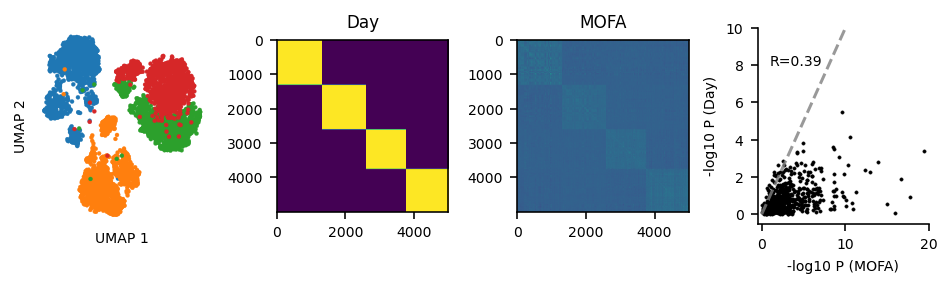

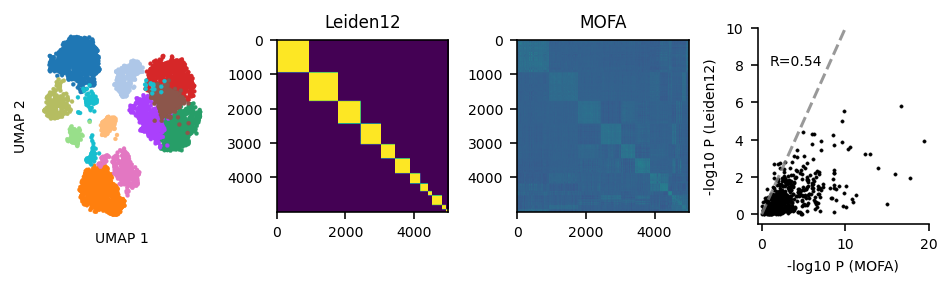

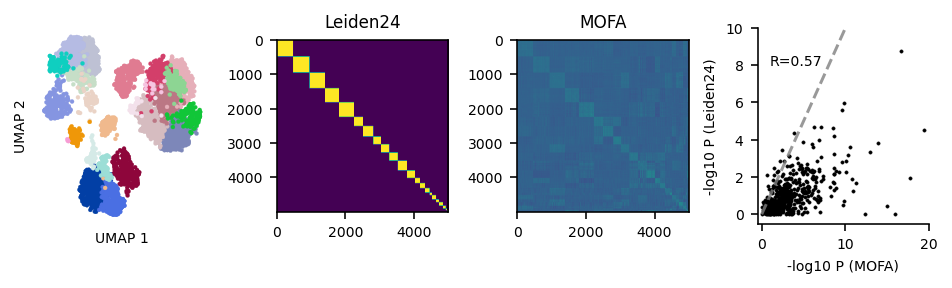

In [59]:
for v in ['day', 'leiden12', 'leiden24']:
    adata = adata[np.argsort(adata.obs[v]).to_numpy(), :]

    K = pd.get_dummies(adata.obs[v])
    K = K @ K.T

    K_mofa = adata.obsm['X_mofa']
    K_mofa = K_mofa @ K_mofa.T

    fig, axes = plt.subplots(1, 4, figsize=(8, 1.8))
    
    # clustering
    emb = sc.get.obs_df(adata, obsm_keys=[('X_umap', 0), ('X_umap', 1)])
    emb[v] = adata.obs[v]
    sns.scatterplot(
        x='X_umap-0', y='X_umap-1', hue=v, 
        data=emb, ax=axes[0], 
        palette=dict(zip(adata.obs[v].cat.categories, adata.uns[f'{v}_colors'])), 
        legend=None, edgecolor=None, s=4)
    axes[0].set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2')
    sns.despine(ax=axes[0], bottom=True, left=True)

    # discrete kernel
    axes[1].imshow(K)
    axes[1].set(title=v.title())
    
    # sorted MOFA kernel
    axes[2].imshow((K_mofa - K_mofa.min()) / (K_mofa - K_mofa.min()).max())
    axes[2].set(title='MOFA')

    # pvals
    sns.scatterplot(x='pvals_mofa', y='pvals_%s' % v, data=df, color='black', edgecolor=None, s=3, ax=axes[3])
    axes[3].plot([0, 20], [0, 20], c='grey', linestyle='--', alpha=0.8)
    axes[3].set(xlabel='-log10 P (MOFA)', ylabel='-log10 P (%s)' % v.title(), xlim=[-0.5, 20], ylim=[-0.5, 10])
    axes[3].text(1, 8, 'R=%.2f' % corr.loc['pvals_%s' % v, 'pvals_mofa'])
    sns.despine(ax=axes[3])
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
    plt.savefig(f"figures/power_discrete_context~{v}.png", dpi=300)
    plt.show()

## FEV GxC

In [10]:
gvar=ensure_list(settings.GENETIC_VAR)
fevgxc=settings.FEV_GXC
ncontexts=[settings.NUM_CONTEXTS_DEFAULT]
model=['cellregmap-association', 'cellregmap', 'cellregmap-fixed-single-env']
ntested=[settings.NUM_TESTED_DEFAULT]

df = create_df(
    gvar=gvar, 
    fevgxc=fevgxc, 
    ncontexts=ncontexts, 
    model=model, 
    context=['mofa'], 
    ntested=ntested)

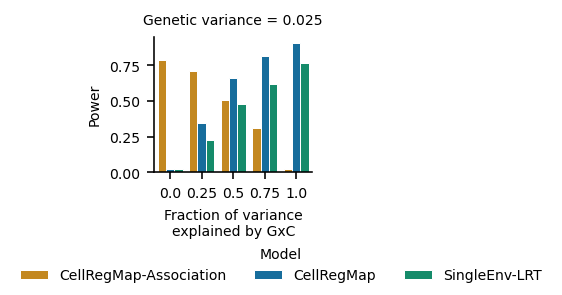

In [11]:
g = sns.catplot(
    x='fevgxc', 
    y='power', 
    hue='Model', 
    col='gvar',
    data=df, 
    palette=model_colors, 
    kind='bar', 
    height=2, 
    aspect=1, 
    linewidth=.5, 
    edgecolor='white')
g.set(xlabel='Fraction of variance\nexplained by GxC', ylabel='Power')

g.set_titles(
    col_template="Genetic variance = {col_name}")
g.fig.subplots_adjust(bottom=.4)
sns.move_legend(g, loc='lower center', ncol=3)
plt.savefig("figures/power_fev.svg", dpi=300)

## Number of simulated contexts

In [12]:
gvar=ensure_list(settings.GENETIC_VAR)
fevgxc=[settings.FEV_GXC_DEFAULT]
ncontexts=settings.NUM_CONTEXTS
model=['cellregmap', 'cellregmap-fixed-single-env']
ntested=[settings.NUM_TESTED[-1]]

df = create_df(
    gvar=gvar, 
    fevgxc=fevgxc, 
    ncontexts=ncontexts, 
    model=model, 
    context=['mofa'], 
    ntested=ntested)

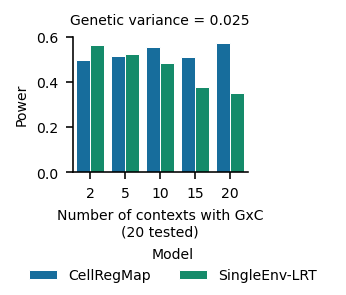

In [13]:
g = sns.catplot(
    x='ncontexts', 
    y='power', 
    hue='Model', 
    col='gvar',
    data=df, 
    palette=model_colors, 
    kind='bar', 
    height=2, 
    aspect=1, 
    linewidth=.5, 
    edgecolor='white')
g.set(xlabel='Number of contexts with GxC\n(20 tested)', ylabel='Power')

g.set_titles(
    col_template="Genetic variance = {col_name}")
g.fig.subplots_adjust(bottom=.4)
sns.move_legend(g, loc='lower center', ncol=3)
plt.savefig("figures/power_ncontexts.svg", dpi=300)

## Number of tested contexts

In [14]:
gvar=ensure_list(settings.GENETIC_VAR)
fevgxc=[settings.FEV_GXC_DEFAULT]
ncontexts=[settings.NUM_CONTEXTS[-1]]
model=['cellregmap', 'cellregmap-fixed-single-env']
ntested=settings.NUM_TESTED

df = create_df(
    gvar=gvar, 
    fevgxc=fevgxc, 
    ncontexts=ncontexts, 
    model=model, 
    context=['mofa'], 
    ntested=ntested)

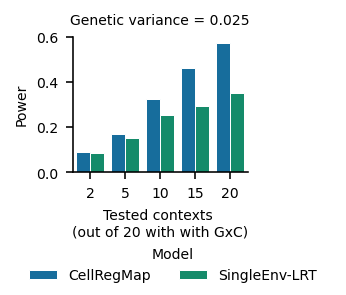

In [15]:
g = sns.catplot(
    x='ntested', 
    y='power', 
    hue='Model', 
    col='gvar',
    data=df, 
    palette=model_colors, 
    kind='bar', 
    height=2, 
    aspect=1, 
    linewidth=.5, 
    edgecolor='white')
g.set(xlabel='Tested contexts \n(out of 20 with with GxC)', ylabel='Power')

g.set_titles(
    col_template="Genetic variance = {col_name}")
g.fig.subplots_adjust(bottom=.4)
sns.move_legend(g, loc='lower center', ncol=3)
plt.savefig("figures/power_ntested.svg", dpi=300)

## Other stats

In [16]:
gvar=ensure_list(settings.GENETIC_VAR)
fevgxc=[settings.FEV_GXC_DEFAULT]
ncontexts=[settings.NUM_CONTEXTS_DEFAULT]
model=['cellregmap-association', 'cellregmap', 'cellregmap-fixed-single-env']
ntested=[settings.NUM_TESTED_DEFAULT]

f = f'../data/simulated/gvar~{gvar[0]}_fevgxc~{fevgxc[0]}_ncontexts~{ncontexts[0]}/adata.h5ad'
adata = sc.read(f)

df = pd.DataFrame()
for i, v in enumerate(product(gvar, fevgxc, ncontexts, model, ['mofa'], ntested)):
    pval = get_pval(load_results(*v))
    r = pd.DataFrame(dict(zip(['gvar', 'fevgxc', 'ncontexts', 'Model', 'context', 'ntested'], v)), index=[i])
    r[pval.index] = pval
    df = pd.concat([df, r])
df['Model'] = df['Model'].replace(model_names)

df = df.melt(value_vars=pval.index, id_vars=['Model', 'gvar'], var_name='gene')
df['gene'] = adata.var_names[df['gene'].astype(int).values]
df['exprs_mean'] = pd.DataFrame(adata.layers['y_base'].mean(0), index=adata.var_names).loc[df['gene'].tolist()].to_numpy()
df['exprs_var'] = pd.DataFrame(adata.layers['y_base'].var(0), index=adata.var_names).loc[df['gene'].tolist()].to_numpy()

from pandas_plink import read_plink1_bin

G = read_plink1_bin(settings.DATA_DIR + '/filtered/genotypes_sim.bed')
maf = pd.Series(G.values.sum(0) / (2 * G.shape[0]), index=G.snp)
df['maf'] = maf.loc[adata.var.loc[df['gene']]['snpID']].tolist()

/omics/groups/OE0540/internal/users/heinent/miniconda3/envs/cellregmap/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 71.24it/s]


In [17]:
df['pval'] = -np.log10(df['value'])

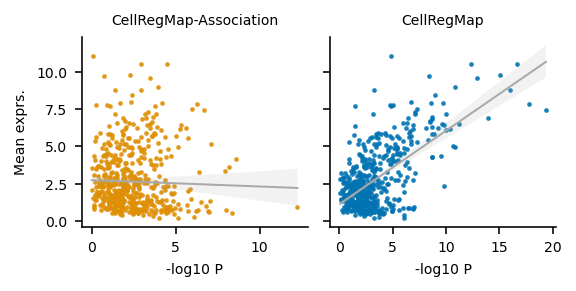

In [18]:
v, l = 'exprs_mean', 'Mean exprs.'

g = sns.lmplot(
    y=v, 
    x='pval', 
    col='Model',
    hue='Model',
    palette=model_colors, 
    height=2,
    robust=True,
    data=df.query('Model != "SingleEnv-LRT"'), 
    facet_kws={'margin_titles': True, 'sharex': False},
    scatter_kws={'s': 2, 'rasterized': True},
    line_kws={'color': 'darkgrey', 'linewidth': 1})
g.set_titles(col_template="{col_name}")
g.set(ylabel=l, xlabel='-log10 P')
plt.savefig(f"figures/power_exprs_mean.svg", dpi=300)

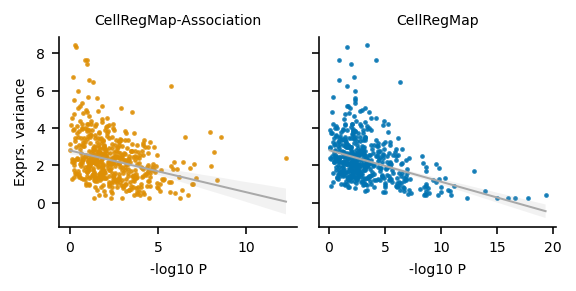

In [19]:
v, l = 'exprs_var', 'Exprs. variance'

g = sns.lmplot(
    y=v, 
    x='pval', 
    col='Model',
    hue='Model',
    palette=model_colors, 
    height=2,
    robust=True,
    data=df.query('Model != "SingleEnv-LRT"'), 
    facet_kws={'margin_titles': True, 'sharex': False},
    scatter_kws={'s': 2, 'rasterized': True},
    line_kws={'color': 'darkgrey', 'linewidth': 1})
g.set_titles(col_template="{col_name}")
g.set(ylabel=l, xlabel='-log10 P')
plt.savefig(f"figures/power_exprs_var.svg", dpi=300)

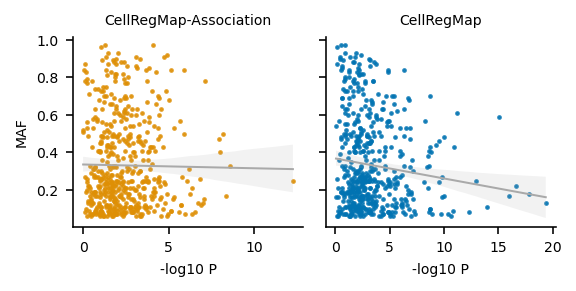

In [20]:
v, l = 'maf', 'MAF'

g = sns.lmplot(
    y=v, 
    x='pval', 
    col='Model',
    hue='Model',
    palette=model_colors, 
    height=2,
    robust=True,
    data=df.query('Model != "SingleEnv-LRT"'), 
    facet_kws={'margin_titles': True, 'sharex': False},
    scatter_kws={'s': 2, 'rasterized': True},
    line_kws={'color': 'darkgrey', 'linewidth': 1})
g.set_titles(col_template="{col_name}")
g.set(ylabel=l, xlabel='-log10 P')
plt.savefig(f"figures/power_maf.svg", dpi=300)